In [2]:
import pandas as pd
from datasets import Dataset # Import Dataset class
from transformers import AutoTokenizer, DataCollatorWithPadding
import tqdm as notebook_tqdm
# Load the saved file
df = pd.read_csv("data/train_cleaned.csv")
# Check for NaNs (sometimes cleaning turns "..." into empty space)
df.dropna(inplace=True)
raw_datasets = Dataset.from_pandas(df)

In [3]:
#Begin tokenization
tokenizer = AutoTokenizer.from_pretrained(
   "distilbert-base-uncased"
)
checkpoint = "distilbert-base-uncased"

In [4]:
def tokenize_function(example):#takes example text and convers to token IDs for computer to understand 
    return tokenizer(example["clean_text"], truncation=True)#shortens text if it goes beyond 512 


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # adds padding to extra spaces of the tokens

Map: 100%|██████████| 16000/16000 [00:04<00:00, 3668.76 examples/s] 


In [ ]:
from transformers import TrainingArguments,EarlyStoppingCallback

training_args = TrainingArguments(
  output_dir="test-trainer",
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    eval_strategy="epoch", 
    save_strategy="epoch",
    save_total_limit=1,           #  only keep the best model checkpoint
    greater_is_better=True,       #  for metrics like f1
)
early = EarlyStoppingCallback(early_stopping_patience=3)

In [16]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# 1. Split the single tokenized_datasets object into two
train_test_split = tokenized_datasets.train_test_split(test_size=0.2, seed=42)

# 2. Extract the training split
train_dataset = train_test_split["train"]

# 3. Extract the evaluation split
eval_dataset = train_test_split["test"]

In [18]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate F1 (Weighted is best for your imbalanced data)
    f1 = f1_score(labels, predictions, average='weighted')
    
    return {"accuracy": accuracy, "f1": f1}

In [19]:
from transformers import Trainer

trainer = Trainer(
    model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    callbacks=[early],
    compute_metrics=compute_metrics,
)

In [20]:
trainer.train()

c:\Users\prisc\Documents\Python\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.278700,0.275149,0.914687,0.915030
2,0.161500,0.213764,0.920625,0.920658
3,0.091000,0.259578,0.919063,0.918865


c:\Users\prisc\Documents\Python\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\prisc\Documents\Python\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=4800, training_loss=0.23566030462582907, metrics={'train_runtime': 11389.0542, 'train_samples_per_second': 3.372, 'train_steps_per_second': 0.421, 'total_flos': 408713845933152.0, 'train_loss': 0.23566030462582907, 'epoch': 3.0})

Generating predictions on validation set...


c:\Users\prisc\Documents\Python\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Advanced Model (DistilBERT) Classification Report:
              precision    recall  f1-score   support

     Sadness     0.9454    0.9751    0.9600       924
         Joy     0.9695    0.9270    0.9478      1096
        Love     0.7584    0.9076    0.8263       249
       Anger     0.9137    0.9159    0.9148       416
        Fear     0.8734    0.8625    0.8679       400
    Surprise     0.8652    0.6696    0.7549       115

    accuracy                         0.9206      3200
   macro avg     0.8876    0.8763    0.8786      3200
weighted avg     0.9231    0.9206    0.9207      3200



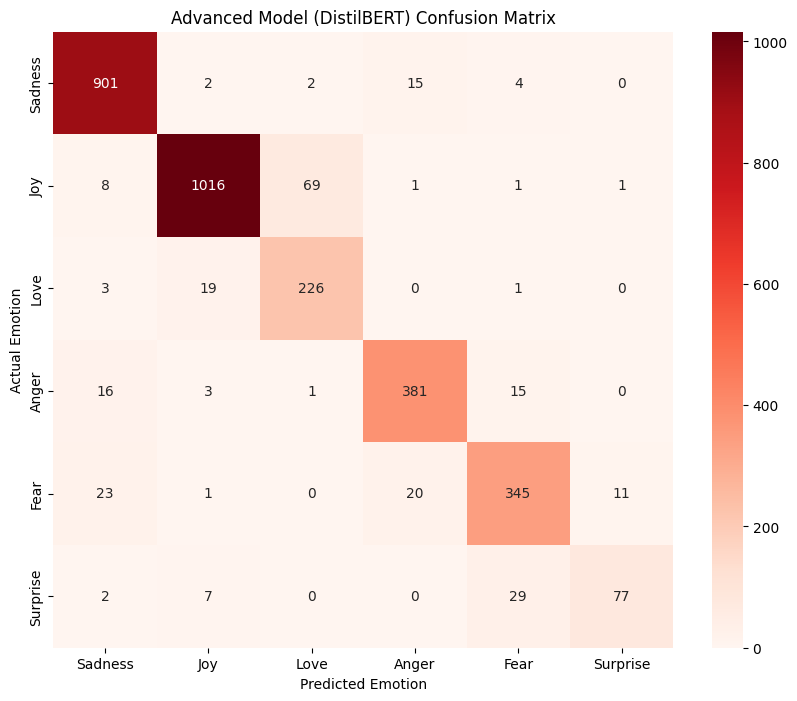

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

#Getting predictions
print("Generating predictions on validation set...")
predictions_output = trainer.predict(eval_dataset)
#Converting probabilities to class numbers
y_preds = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids
# Define Names
target_names = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']
#Print Report
print("\nAdvanced Model (DistilBERT) Classification Report:")
print(classification_report(y_true, y_preds, target_names=target_names, digits=4))
# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(10,8))
# We use 'Reds' heatmap to distinguish it from the Blue Baseline one
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual Emotion')
plt.xlabel('Predicted Emotion')
plt.title('Advanced Model (DistilBERT) Confusion Matrix')
plt.show()